# Chess Data Analysis



As a lifelong chess player, I have always wanted to know more about how other players play and learn from different ideas and playstyles. With newfound abilities to analyze large amounts of data and visualize them, I decided to take a look at group of 20,058 games and learn something from them. In particular, I wanted to answer two questions:



1.   How does the rating spread (difference) between players affect the games played?
2.   What openings were the most popular, and how successful were they for each color?

The first step, using [data from Kaggle](https://www.kaggle.com/datasnaek/chess), was to process the data into a pandas DataFrame:





In [ ]:
# Upload Chess Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import seaborn as sb
import chess
from google.colab import files
data_to_load = files.upload()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Saving games.csv to games.csv


In [ ]:
import io
chess_data = pd.read_csv(io.BytesIO(data_to_load['games.csv']))

chess_data.loc[10000:10005]

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
10000,n0wlzNTy,True,1.409038e+12,1.409039e+12,55,draw,draw,60+5,lile,1291,dakotarain,1117,e4 e5 Nf3 d5 Nxe5 dxe4 d4 f6 Bb5+ c6 Qh5+ Ke7 ...,C40,Elephant Gambit,4
10001,wakRkkiN,False,1.409035e+12,1.409037e+12,44,outoftime,black,30+0,julia_tatar,1152,dakotarain,1117,e4 e5 d4 f6 Nf3 d5 exd5 e4 Bb5+ c6 dxc6 bxc6 B...,C21,Center Game #2,3
10002,6pr8wnef,True,1.379707e+12,1.379708e+12,108,resign,black,12+2,mpumprla,1121,kamilahhuds,1458,e4 g6 b3 e5 Nf3 Bg7 Bb2 Nc6 Bc4 d6 O-O Nf6 d4 ...,B06,Modern Defense,2
10003,70m4wihn,True,1.379413e+12,1.379414e+12,56,mate,black,10+2,efiop,1580,kamilahhuds,1402,e4 e5 Qf3 Nf6 c3 Nc6 Bc4 Be7 Ne2 O-O d4 d6 dxe...,C20,King's Pawn Game: Napoleon Attack,3
10004,xemwuhlw,False,1.379370e+12,1.379370e+12,7,resign,white,8+5,kamilahhuds,1023,charles8,879,e4 e5 c4 Qh4 Nf3 Qxe4+ Be2,C20,English Opening: The Whale,3
10005,9944m389,True,1.379366e+12,1.379367e+12,51,mate,white,15+12,kamilahhuds,1354,mrcesarchess,1389,e4 d6 c4 Na6 d4 e6 d5 e5 Bd2 Bd7 Nf3 Nf6 Bd3 B...,B07,Pirc Defense #4,2


After the data was converted from a csv to a DataFrame, the next step was to reorganize the DataFrame in a manner that was easier to develop visuals from.

In [ ]:
elap_time = chess_data['last_move_at'] - chess_data['created_at']
elap_time = elap_time * 1E-3 / 60
turns = chess_data['turns']
game_type = chess_data['increment_code']
time = []
inc = []

for val in game_type:
  val = str(val)
  val1 = ''
  val2 = ''
  i = 0
  for let in val:
    if let == '+':
      i += 1
    elif i != 0:
      val2 += let
    elif let != '+':
      val1 += let
  val1 = int(val1)
  val2 = int(val2)
  time.append(val1)
  inc.append(val2)

time = pd.Series(time)
inc = pd.Series(inc)
vic_type = chess_data['victory_status']
win = chess_data['winner']
w_rat = chess_data['white_rating']
b_rat = chess_data['black_rating']
dif_rate = abs(w_rat - b_rat)
opening_moves = chess_data['opening_eco']
open_type = chess_data['opening_name']
open_ply = chess_data['opening_ply']
up_games = []
ups = []
for game in chess_data.index:
  dat = chess_data.loc[game]
  if dat['winner'] == 'white' and dat['black_rating'] > dat['white_rating']:
    ups.append(1)
    up_games.append(game)
  elif dat['winner'] == 'black' and dat['white_rating'] > dat['black_rating']:
    ups.append(1)
    up_games.append(game)
  else:
    ups.append(0)
upset = pd.Series(ups)
print(len(up_games))


data = pd.DataFrame({'Total Time (min)': elap_time, 'Turns': turns,
                           'Min per Side': time, 'Sec. added per Move': inc, 'Victory Type': vic_type,
                        'Winner': win, 'White Rating': w_rat,
                        'Black Rating': b_rat, 'Rating Spread': dif_rate, 'Upset': upset,
                        'Opening Moves': opening_moves, 'Opening Name': open_type,
                        'Opening Ply': open_ply})

data.loc[10000:10005]

6566


,Total Time (min),Turns,Min per Side,Sec. added per Move,Victory Type,Winner,White Rating,Black Rating,Rating Spread,Upset,Opening Moves,Opening Name,Opening Ply
10000,21.752750,55,60,5,draw,draw,1291,1117,174,0,C40,Elephant Gambit,4
10001,34.912667,44,30,0,outoftime,black,1152,1117,35,1,C21,Center Game #2,3
10002,15.436550,108,12,2,resign,black,1121,1458,337,0,B06,Modern Defense,2
10003,9.544367,56,10,2,mate,black,1580,1402,178,1,C20,King's Pawn Game: Napoleon Attack,3
10004,0.993583,7,8,5,resign,white,1023,879,144,0,C20,English Opening: The Whale,3
10005,10.732033,51,15,12,mate,white,1354,1389,35,1,B07,Pirc Defense #4,2


After reorganizing the data, the first inquiry was made into which openings out of all the games played were the most common lines:

In [ ]:
openings = data['Opening Name']
opening = pd.DataFrame({'Opening Name': openings})
opening.apply(pd.value_counts)

,Opening Name
Van't Kruijs Opening,368
Sicilian Defense,358
Sicilian Defense: Bowdler Attack,296
French Defense: Knight Variation,271
Scotch Game,271
...,...
Benoni Defense: Benoni Gambit | Schlenker Defense,1
Queen's Pawn Game: Englund Gambit,1
Zukertort Opening: Basman Defense,1
Modern Defense: Pseudo-Austrian Attack,1


With the knowledge of the most popular openings, the questions could start to be answered in the form of visuals. For the first question, I theorized that there would be a relationship between the rating spread of a game and the number of turns made. A scatter plot was made to see if that hypothesis was correct:

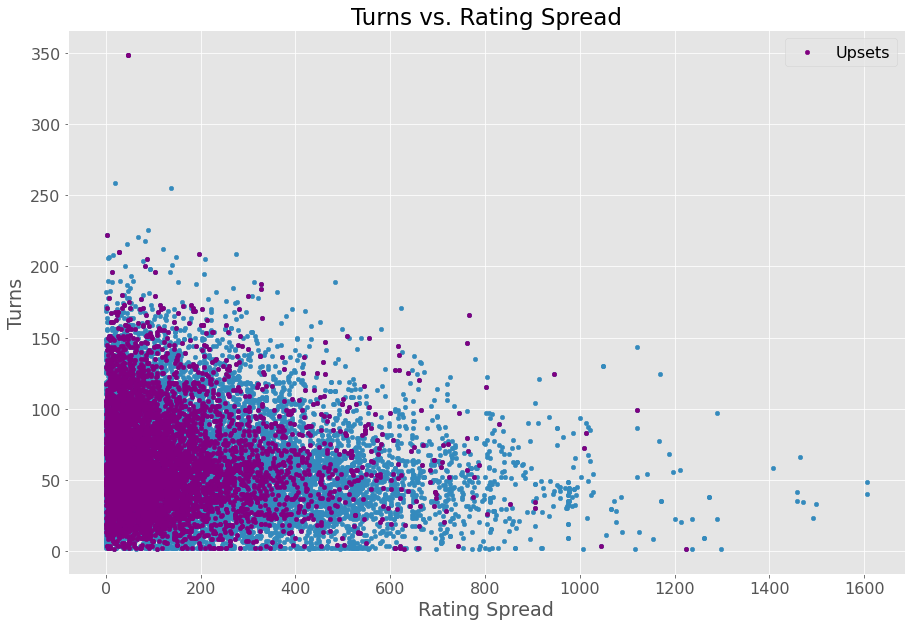

In [ ]:
plt.rcParams['figure.figsize'] = (15, 10) 
plt.style.use('ggplot')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

up_turn = []
up_spr = []
for val in up_games:
  game = data.loc[val]
  up_turn.append(game['Turns'])
  up_spr.append(game['Rating Spread'])

up_turn = pd.Series(up_turn)
up_spr = pd.Series(up_spr)

spread = pd.Series(data['Rating Spread'])
turns = pd.Series(data['Turns'])
upset = data['Upset']
size = 20
fig1 = pd.DataFrame({'Rating Spread': spread, 'Turns': turns})
fig2 = pd.DataFrame({'Rating Spread': up_spr, 'Turns': up_turn})
TvSpr = fig1.plot.scatter(x = 'Rating Spread', y = 'Turns', s = size)
fig2.plot.scatter(x = 'Rating Spread', y = 'Turns', s = size, color = 'purple', label = 'Upsets', ax = TvSpr)
TvSpr.set_title('Turns vs. Rating Spread')
TvSpr

From the data shown, there were two parts that stood out. First, as would be expected for most online games, the vast majority of those played had a relatively small rating spread. Secondly, there did seem to be fewer turns played in each game as the rating spread increased. Simply put, this is because rating is a good indicator of a player's skill, thus if the rating spread was high there would be a large skill imbalance and therefore the better player would require fewer turns to beat their opponent. However, in addition to the relationship between turns and rating spread, I wanted to see how the skill disparity affected the victory type for each game. The second figure shows the percentage of wins for games of three distinct bin ranges. Since there were fewer games played as the rating spread increased, the bin ranges increase in size as the spread increases:

In [ ]:
bins = pd.cut(data['Rating Spread'], [0, 100, 300, 800, 1600],
              labels = ['0-100', '101-300', '301-800', '801-1600'],
              retbins = True)

bin1 = []
bin2 = []
bin3 = []
bin4 = []

i = 0
for val in bins[0]:
  if val == '0-100':
    bin1.append(i)
  elif val == '101-300':
    bin2.append(i)
  elif val == '301-800':
    bin3.append(i)
  elif val == '801-1600':
    bin4.append(i)
  i += 1



In [ ]:
vic1 = []
vic2 = []
vic3 = []
vic4 = []
for num in bin1:
  victory = data.loc[num]['Victory Type']
  vic1.append(victory)

for num in bin2:
  victory = data.loc[num]['Victory Type']
  vic2.append(victory)

for num in bin3:
  victory = data.loc[num]['Victory Type']
  vic3.append(victory)

for num in bin4:
  victory = data.loc[num]['Victory Type']
  vic4.append(victory)

Text(0.5, 0, '% of Victories')

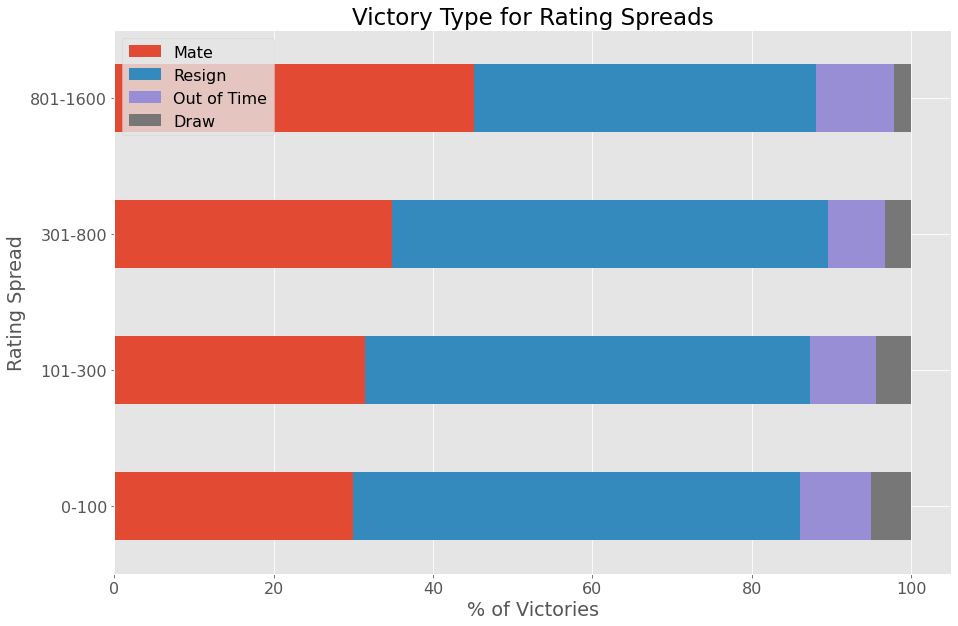

In [ ]:
def tally(vic_list):
  """Takes a list of victory types for a range of Rating Spreads and returns
  a Series which tallies each victory type for the range"""
  draw = 0
  Res = 0
  oot = 0
  mate = 0
  for vic_typ in vic_list:
    if vic_typ == 'mate':
      mate += 1
    elif vic_typ == 'outoftime':
      oot += 1
    elif vic_typ == 'resign':
      Res += 1
    else:
      draw += 1
  return pd.Series({'Mate': mate, 'Resign': Res, 'Out of Time': oot,
                    'Draw': draw})
  
L = tally(vic1) * 100 / len(bin1)
M = tally(vic2) * 100 / len(bin2)
H = tally(vic3) * 100 / len(bin3)
wide = tally(vic4) * 100 / len(bin4)

df = pd.DataFrame({'0-100': L, '101-300': M, '301-800': H, '801-1600': wide})
df = df.transpose()
Spr_vic = df.plot(kind = 'barh', stacked = True)
Spr_vic.set_title('Victory Type for Rating Spreads')
Spr_vic.set_ylabel('Rating Spread')
Spr_vic.set_xlabel('% of Victories')

As can be seen, each bar represents all the win types for games with a rating spread within its respective bin. Surprisingly, the differences in the percentages of win types didn't differ all that significantly. However, one trend did consistently stand out; the greater the rating spread, the more likely the victory type was a checkmate. Upon consideration, this might make sense for a few reasons. To begin with, a player with much less experience/skill than their opponent might be much less aware of their impending demise than a match between more evenly matched opponents. In addition, the likelihood of a draw occurring in that situation would also be much less likely, thus increasing the chances of a checkmate. Lastly, while less prevalent in lower rating spread bins, in the highest rating spreads there is a noticable drop in resignations, another piece of evidence which would lend itself to the theory that the weaker player may not even realize their fate until it is sealed. 

Ultimately, the data revealed what would be expected from a large sample size of games; the larger the disparity in skill level, the fewer turns it takes on average to win the game for the higher rated player and the more like they are to do so via checkmate.

In approaching the second question, knowing what the most used openings of the sample size were, I wanted to know what the win percentages were for white and black on each of the three most popular opening line. 

Text(0.5, 0, 'Win %')

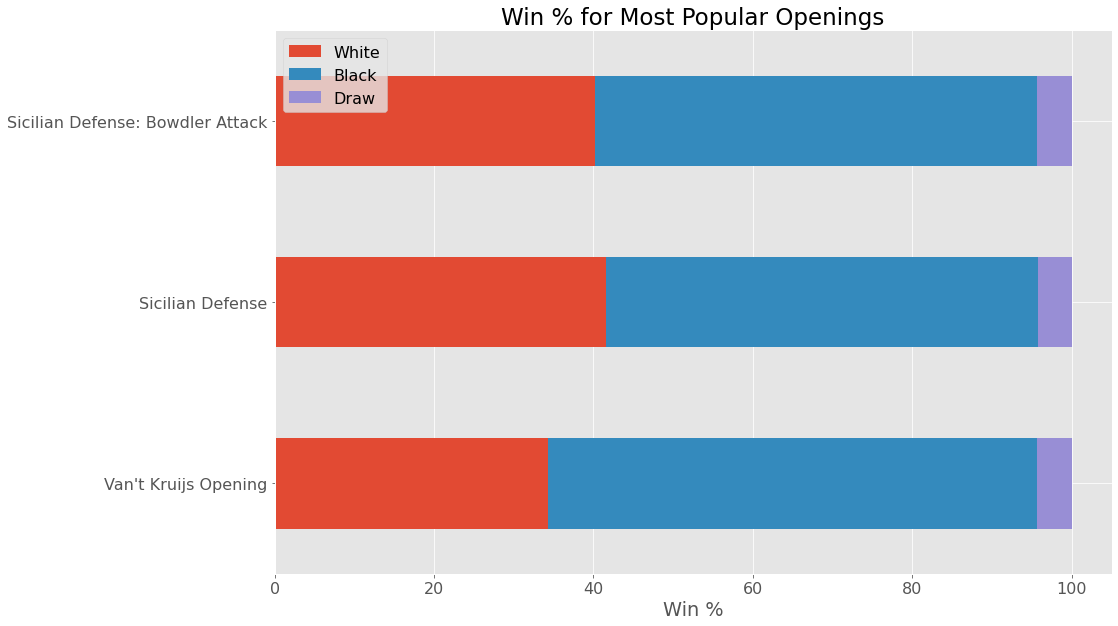

In [ ]:
def WL(win_list):
  """Takes the list of winners for each game of a given opening strategy and
   returns the tally series for white/black/draw"""
  White = 0
  Black = 0
  Draw = 0
  for winner in win_list:
    if winner == 'white':
      White += 1
    elif winner == 'black':
      Black += 1
    else:
      Draw += 1
  return pd.Series({'White': White, 'Black': Black, 'Draw': Draw})

open_chess = data.set_index('Opening Name')

VKO = open_chess.loc['Van\'t Kruijs Opening']['Winner']
SD = open_chess.loc['Sicilian Defense']['Winner']
SD_BA = open_chess.loc['Sicilian Defense: Bowdler Attack']['Winner']

win_opening = pd.DataFrame({'Van\'t Kruijs Opening': WL(VKO) * 100 / VKO.count(),
                            'Sicilian Defense': WL(SD) * 100 / SD.count(),
                            'Sicilian Defense: Bowdler Attack':
                            WL(SD_BA) * 100 / SD_BA.count()})
win_opening = win_opening.transpose()

win_perc = win_opening.plot(kind = 'barh', stacked = True)
win_perc.set_title('Win % for Most Popular Openings')
win_perc.set_xlabel('Win %')

From looking at the data it was clear that for all of the most popular openings black won the majority of the games, in particular on the most widely used opening in the sample size, the Van't Kruijs Opening. Out of curiosity, I wanted to see a popular opening in which white was the most likely victor:

In [ ]:
white = data.set_index('Winner')
white = white.loc['white']
white = white['Opening Name']
white.value_counts()

Scandinavian Defense: Mieses-Kotroc Variation                           164
Sicilian Defense                                                        149
Scotch Game                                                             145
French Defense: Knight Variation                                        135
Philidor Defense #3                                                     127
                                                                       ... 
Sicilian Defense: Najdorf Variation |  Zagreb (Fianchetto) Variation      1
King's Indian Attack: French Variation                                    1
Englund Gambit Complex: Soller Gambit Deferred                            1
Bishop's Opening: Philidor Variation                                      1
English Opening: Mikenas-Carls Variation                                  1
Name: Opening Name, Length: 1181, dtype: int64

In [ ]:
black = data.set_index('Winner')
black = black.loc['black']
black = black['Opening Name']
black.value_counts()

Van't Kruijs Opening                                                          226
Sicilian Defense                                                              194
Sicilian Defense: Bowdler Attack                                              164
Scandinavian Defense                                                          123
French Defense: Knight Variation                                              121
                                                                             ... 
King's Gambit Accepted |  Dodo Variation                                        1
French Defense: Winawer Variation |  Advance Variation |  Moscow Variation      1
Nimzo-Indian Defense: Normal Variation |  Ragozin Variation                     1
Queen's Gambit Declined: Modern |  Knight Defense                               1
Polish Opening: Schiffler-Sokolsky Variation                                    1
Name: Opening Name, Length: 1145, dtype: int64

Text(0.5, 1.0, 'Successful Openings for Black/White')

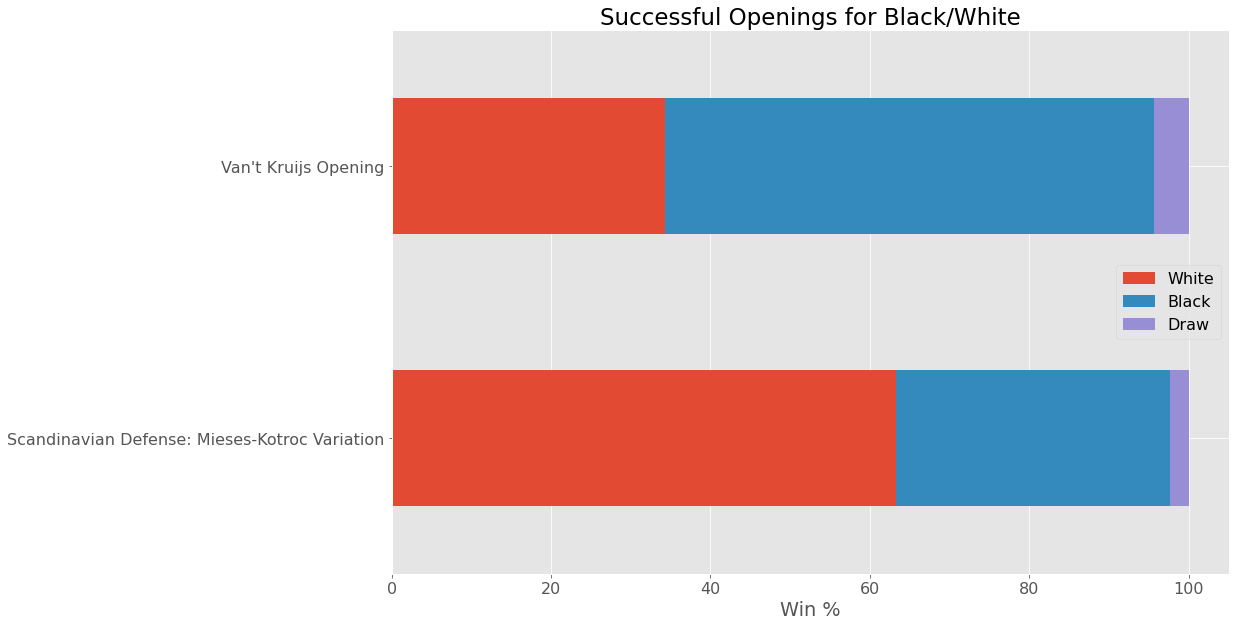

In [ ]:
SD_MKV = open_chess.loc['Scandinavian Defense: Mieses-Kotroc Variation']['Winner']

comp = pd.DataFrame({
    'Scandinavian Defense: Mieses-Kotroc Variation':
     WL(SD_MKV) * 100 / SD_MKV.count(),
      'Van\'t Kruijs Opening': WL(VKO) * 100 / VKO.count()})
comp = comp.transpose()
succ_strat = comp.plot(kind = 'barh', stacked = True)
succ_strat.set_xlabel('Win %')
succ_strat.set_title('Successful Openings for Black/White')

With the comparison between the two, I decided to research the two openings and analyze why one side had such an advantage statistically for each of the following openings, so I looked up each one:

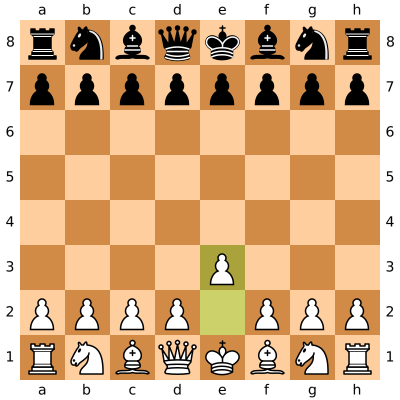

In [ ]:
Van = chess.Board()
Van.push_san('e3')
Van

This was where, immediately, I realized what was happening. In this opening, white has effectively given up the initiative to control the center of the board by only moving their pawn to e3. It is considered a passive move, and suddenly black has gone from relinquishing the middle of the board to having the opportunity to control it with initiative, not a common position black is in. To put that another way, this is a bad opening for white, and one which, statistically, notably reduces their chances of winning the game. Now to observe the other opening:

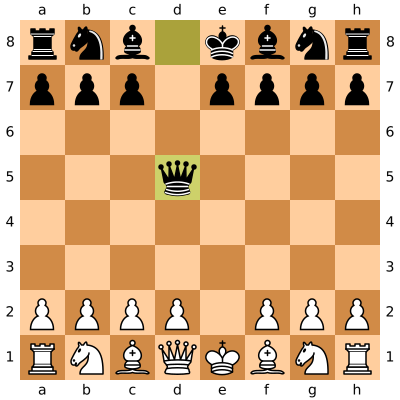

In [ ]:
scan = chess.Board()
scan.push_san('e4')
scan.push_san('d5')
scan.push_san('e4xd5')
scan.push_san('Qxd5')
scan

In this line, white and black have exchanged middle pawns, however black has taken back by using their queen. This is a *very* risky move in the early game, as white can begin developing their pieces into the middle and begin running the queen around as it is exposed and without initiative or supporting pieces around. Unless black is very experienced, they can find themselves with their back to the wall very quickly, which is why statistically speaking the odds of black winning the game have gone down notably at this point.

After observing the two opening and considering what caused the disparity in win percentages for either side, the last piece of information I wanted to know was the frequency white or black made their first move as. A heatmap modeling the chess board shows such a frequency:

In [ ]:
first = chess_data['moves']

moves_W = []

for move in first:
  w = ''
  for val in move:
    if val != ' ':
      w += val
    elif val == ' ':
      break
  moves_W.append(w)

moves_w = pd.value_counts(moves_W)

In [ ]:
moves_B = []

for move in first:
  b = ''
  i = 0
  for val in move:
    if val != ' ' and i == 1:
      b += val
    elif val == ' ' and i == 0:
      i += 1
    elif val != ' ' and i == 0:
      None
    elif val == ' ' and i == 1:
      break
  moves_B.append(b)

moves_b = pd.value_counts(moves_B)

moves = pd.DataFrame({'White': moves_w, 'Black': moves_b})
moves.transpose()

,,Na3,Na6,Nc3,Nc6,Nf3,Nf6,Nh3,Nh6,a3,a4,a5,a6,b3,b4,b5,b6,c3,c4,c5,c6,d3,d4,d5,d6,e3,e4,e5,e6,f3,f4,f5,f6,g3,g4,g5,g6,h3,h4,h5,h6
White,NaN,4.0,NaN,99.0,NaN,725.0,NaN,15.0,NaN,27.0,28.0,NaN,NaN,173.0,88.0,NaN,NaN,56.0,716.0,NaN,NaN,131.0,4522.0,NaN,NaN,416.0,12598.0,NaN,NaN,23.0,166.0,NaN,NaN,186.0,38.0,NaN,NaN,14.0,33.0,NaN,NaN
Black,18.0,NaN,6.0,NaN,392.0,NaN,1693.0,NaN,12.0,NaN,NaN,23.0,50.0,NaN,NaN,25.0,286.0,NaN,NaN,2883.0,734.0,NaN,NaN,3667.0,543.0,NaN,NaN,6988.0,2083.0,NaN,NaN,166.0,41.0,NaN,NaN,18.0,387.0,NaN,NaN,24.0,19.0


Text(0.5, 1.0, 'Heatmap of Opening Moves')

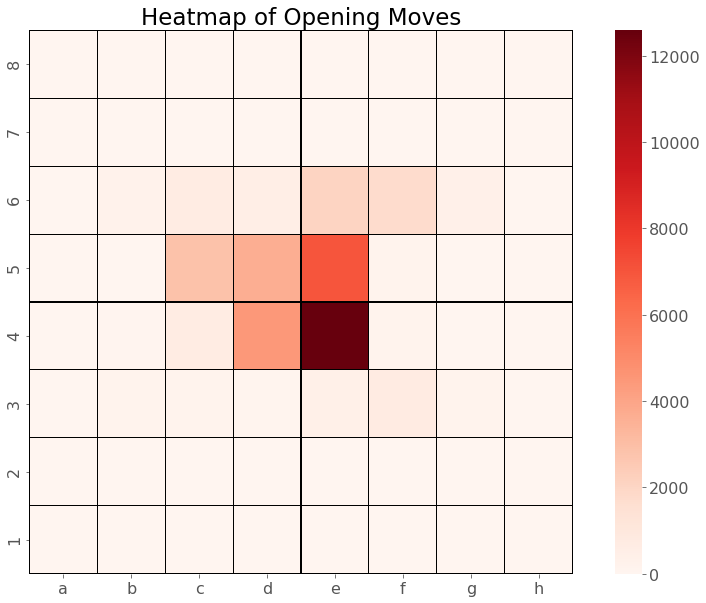

In [ ]:
row = ['1', '2', '3', '4', '5', '6', '7', '8']
column = [None, None, None, None, None, None, None, None]
a = [0, 0, 31, 28, 23, 6, 0, 0]
b = [0, 0, 173, 88, 25, 286, 0, 0]
c = [0, 0, 99 + 56, 716, 2883, 734, 0, 0]
d = [0, 0, 134, 4522, 3667, 543, 0, 0]
e = [0, 0, 416, 12589, 6988, 2083, 0, 0]
f = [0, 0, 725 + 23, 166, 166, 41 + 1693, 0, 0]
g = [0, 0, 186, 38, 18, 387, 0, 0]
h = [0, 0, 15 + 14, 33, 24, 12 + 19, 0, 0]
mlist = [row, a, b, c, d, e, f, g, h]


for lists in mlist:
  lists.reverse()


board_open = pd.DataFrame({'a': a, 'b': b, 'c': c, 'd': d,
                      'e': e, 'f': f, 'g': g, 'h': h},
                      index = row)

board = sb.heatmap(board_open, cmap = 'Reds', square = True, linewidths = .1, linecolor = 'black')
board.set_title('Heatmap of Opening Moves')

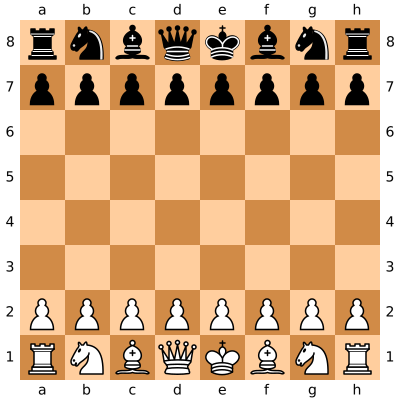

In [ ]:
chess.Board()

This may be hands down one of the most useful heatmaps for beginners to view, as it shows through 20,058 games that the four middle squares are *overwhelmingly* the most played first move for the vast majority of chess players. From experience I can say that a move that lacks intent to make a play for the center of the board is an immediate sign that the player lack experience, and this shows why. In addition, it shows why the most widely used opening was actually one of the weaker openings white could make; by instead moving that pawn to e4 (apparently the most popular opening in chess), the pawn can immediately put control on the middle squares and take advantage of its initiative with the first turn.

To summarize, while the rating spread lacked an incredibly significant impact on the games played (based on the data points analyzed), the increase in spread did trend towards fewer turns per game and a greater chance for checkmate to occur. Breaking down the most popular openings, the success rates for either side ultimately came down to the opening type just being a bad decision for the side which had the lower chance of winning. As for the most popular first moves, the heatmap clearly showed that control of the center of the board was pivotal to a successful game, a lesson which can never be learned too soon for any aspiring chess players. Further investigation could include analysis into openings for players of a certain caliber of rating, and potentially heatmaps for entire games to observe the shifting nature of the board as games progress.



---
#JR Notes: 

Impressive, and good independent work too!  So happy to have you in the class.
